In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and prepare the data
file_path = 'IBM_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.drop('Name', axis=1)


In [2]:
# Identify missing days 
all_days = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

missing_days = all_days.difference(data.index)

missing_days_df = pd.DataFrame(missing_days, columns=['MissingDate'])
missing_days_df['DayOfWeek'] = missing_days_df['MissingDate'].dt.day_name()

print("Missing days with day of the week:")
print(missing_days_df)

pattern_analysis = missing_days_df['DayOfWeek'].value_counts()
print("\nPattern of missing days by day of the week:")
print(pattern_analysis)

Missing days with day of the week:
     MissingDate DayOfWeek
0     2006-01-07  Saturday
1     2006-01-08    Sunday
2     2006-01-14  Saturday
3     2006-01-15    Sunday
4     2006-01-16    Monday
...          ...       ...
1354  2017-12-16  Saturday
1355  2017-12-17    Sunday
1356  2017-12-23  Saturday
1357  2017-12-24    Sunday
1358  2017-12-25    Monday

[1359 rows x 2 columns]

Pattern of missing days by day of the week:
DayOfWeek
Saturday     625
Sunday       625
Monday        59
Friday        21
Thursday      17
Tuesday        8
Wednesday      4
Name: count, dtype: int64


In [3]:
# NaN values
data[data.isna().any(axis=1)]

,Open,High,Low,Close,Volume
Date,,,,,
2017-07-31,NaN,144.93,NaN,144.67,4355718


In [4]:
# cleanup
data_resampled = data.asfreq('D')
data_resampled = data_resampled.interpolate(method='time')

# Transformer

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting needed

    def transform(self, X):
        return X  # Return input unchanged

    def inverse_transform(self, X):
        return X  # Return input unchanged


In [6]:
# Resample and interpolate missing values
data_resampled = data.asfreq('D')
data_resampled = data_resampled.interpolate(method='time')
data_resampled = data_resampled.to_numpy()

# Normalize the data
# scaler = RobustScaler()
# data_resampled = scaler.fit_transform(data_resampled)
n_features = data_resampled.shape[1] - 1

In [7]:
# Prepare the dataset for Transformer

T = 7  # Time lag 
def make_sequence(data_resampled, T, target_index):
    X, Y = [], []
    for t in range(len(data_resampled) - T):
        X.append(data_resampled[t:t + T, [j for j in range(data.shape[1]) if j != target_index]])
        Y.append(data_resampled[t + T, target_index])

    return np.array(X), np.array(Y)


# Split into training and testing sets
split_ratio = 0.8
split_index = int(data_resampled.shape[0] * split_ratio)

data_train = data_resampled[:split_index]
data_test = data_resampled[split_index:]
target_index = data.columns.get_loc('Close')

# scaling
y_scaler = RobustScaler()
y_scaler.fit(data_train[:, target_index].reshape(-1, 1))

scaler = RobustScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

X_train, Y_train = make_sequence(data_train, 7, target_index)
X_test, Y_test = make_sequence(data_test, 7, target_index)

# Reshape for Transformer (batch_size, seq_len, feature_dim)
X_train = X_train.reshape(-1, T, n_features)
X_test = X_test.reshape(-1, T, n_features)


In [8]:
# Define Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):

    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout, attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Network
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


In [9]:
# Build Transformer Model
def build_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0):
    n_timesteps, n_features, n_outputs = T, 4, 1
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs)

transformer = build_transformer(head_size=128, num_heads=4, ff_dim=64, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10)

# Compile and train the Transformer
def fit_transformer(transformer, X_train, Y_train):

    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", "mape"]
    )

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    history = transformer.fit(X_train, 
                              Y_train, 
                              batch_size=32,
                              epochs=50, 
                              verbose=1, 
                              callbacks=callbacks)
    return history

history = fit_transformer(transformer, X_train, Y_train)


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1428 - mae: 0.3047 - mape: 26470.4902
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0713 - mae: 0.2156 - mape: 72887.1094
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0594 - mae: 0.1983 - mape: 15190.0078
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0553 - mae: 0.1928 - mape: 125196.6172
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0404 - mae: 0.1615 - mape: 9520.9590
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0309 - mae: 0.1369 - mape: 12483.2031
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0260 - mae: 0.1263 - mape: 54315.9883
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0245 - mae: 0.1222 - mape: 17589.3359
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0230 - mae: 0.1139 - mape: 8945.7578
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0244 - mae: 0.1241 - mape: 42

In [10]:

# Predict on the test set
Y_pred = transformer.predict(X_test)
Y_pred = y_scaler.inverse_transform(Y_pred.reshape(-1, 1)).flatten()
Y_test_rescaled = y_scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()
# Y_test_rescaled = Y_test

# Evaluate the model
mse = mean_squared_error(Y_test_rescaled, Y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Squared Error on Test Set: 5.0411


Mean Squared Error (MSE): 5.0411
Mean Absolute Error (MAE): 1.6757
Mean Absolute Percentage Error (MAPE): 1.11%


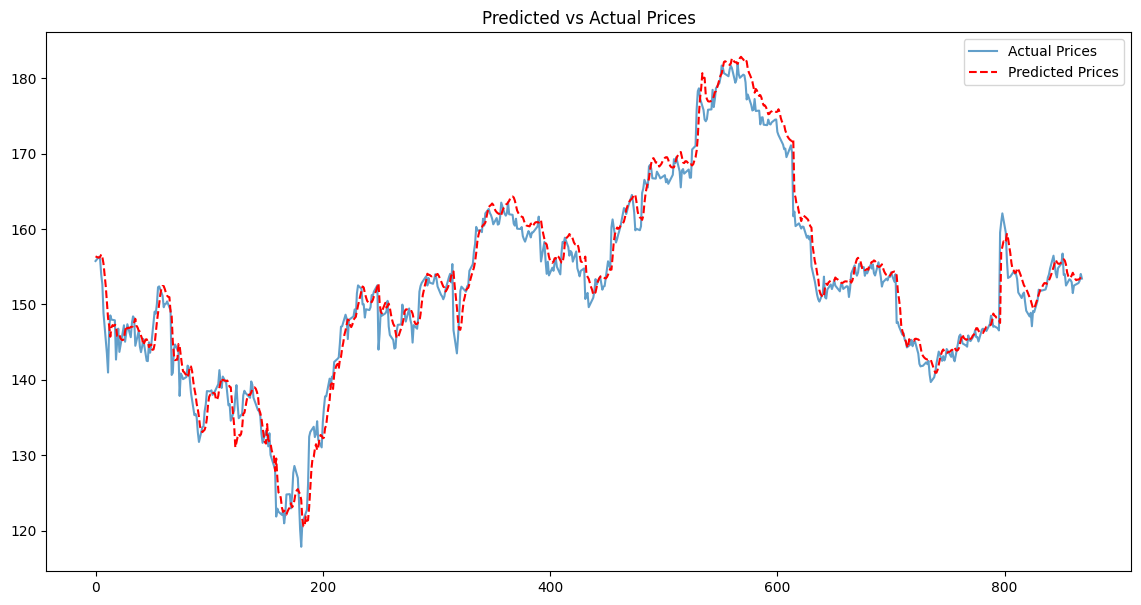

In [11]:
# Calculate metrics
mse = mean_squared_error(Y_test_rescaled, Y_pred)
mae = np.mean(np.abs(Y_test_rescaled - Y_pred))
mape = np.mean(np.abs((Y_test_rescaled - Y_pred) / Y_test_rescaled)) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(Y_test_rescaled, label="Actual Prices", alpha=0.7)
plt.plot(Y_pred, label="Predicted Prices", linestyle="--", color="red")
plt.title("Predicted vs Actual Prices")
plt.legend()
plt.show()

In [12]:
transformer.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 7, 4)      │          8 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 4)      │      9,732 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 4)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 7, 4)      │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 7, 64)     │        320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 7, 64)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 7, 4)      │        260 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 7, 4)      │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 4)      │      9,732 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 7, 4)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 7, 4)      │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 7, 64)     │        320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 7, 64)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 7, 4)      │        260 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 7, 4)      │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 130,853 (511.15 KB)

 Trainable params: 43,617 (170.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 87,236 (340.77 KB)